In this notebook, you will:
- Engineer features for machine learning
- Train a logistic regression model to classify emails
- Evaluate the model's performance
- Test whether sentiment features significantly contribute to classification

Your end goal: Build a model that predicts phishing emails accurately and explain the role of sentiment features.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

Load the prepared dataset containing:
- Sentiment scores
- TF-IDF features
- Target variable (email_type)

We'll separate features (X) from the target label (y).

In [14]:
df = pd.read_parquet('../DATA/final.parquet')

'X' will contain all feature columns (sentiment + TF-IDF).

'y' will contain the target variable (email_type: 0 = safe, 1 = phishing).

In [15]:
X = df.drop(columns=['email_type'])
y = df['email_type']

We split the data to evaluate how well our model generalizes to unseen data.
Use an 80/20 split and stratify by 'y' to preserve class balance.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=df['email_type'])

Logistic Regression is a strong baseline for binary classification tasks like this. We'll fit the model on the training data.

In [17]:
# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()



After training, predict labels for the test set.
Calculate and print:
- Accuracy score
- Precision, Recall, F1 Score

These metrics tell us how well the model identifies phishing emails without too many false positives.

In [18]:
# Predict on the test set and calculate accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       243
           1       0.96      0.87      0.91       157

    accuracy                           0.93       400
   macro avg       0.94      0.92      0.93       400
weighted avg       0.93      0.93      0.93       400



Is there a significant difference between the compound (average) sentiment of phishing vs. safe emails? A t-test helps us measure the difference.

In [19]:
# T-test to evaluate statistical significance of sentiment score between phishing and safe emails
phishing_scores = df[df['email_type'] == 1]['compound']
safe_scores = df[df['email_type'] == 0]['compound']
t_stat, p_value = ttest_ind(phishing_scores, safe_scores, equal_var=False)

In [20]:
# Compile results
results = {
    'Model Accuracy': f"{accuracy:.2%}",
    'T-Test Statistic': float(t_stat),
    'P-Value': float(p_value),
    'Significant (p < 0.0001)': bool(p_value < 0.0001)
}

results

{'Model Accuracy': '94.00%',
 'T-Test Statistic': 5.272299135996519,
 'P-Value': 1.5109858717844738e-07,
 'Significant (p < 0.0001)': True}

5-fold validation and bootstrapping help us ensure the validity of our model. How consistent does the model perform across different resamplings of the original data?

In [21]:
# 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = np.mean(cv_scores)
std_dev = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Accuracy Std Dev: {std_dev:.4f}")

Mean Accuracy: 0.9256
Accuracy Std Dev: 0.0103


In [28]:
# Number of bootstrap samples
n_iterations = 100
scores = []

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=100)
    log_reg.fit(X_resampled, y_resampled)
    y_pred = log_reg.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))  

# Compute 95% confidence interval
lower = np.percentile(scores, 2.5)
upper = np.percentile(scores, 97.5)

print(f"95% Confidence Interval for Accuracy: [{lower:.4f}, {upper:.4f}]")

still working
95% Confidence Interval for Accuracy: [0.9325, 0.9325]


Logistic Regression produces coefficients for each feature. Large positive or negative coefficients suggest important predictors.

You can inspect the top words or sentiment scores most associated with phishing emails.

In [30]:
feature_names = X.columns
coef = log_reg.coef_[0]

In [31]:
feature_coef_dict = dict(zip(feature_names, coef))
sorted_features = sorted(feature_coef_dict.items(), key=lambda x: x[1], reverse=True)

In [32]:
# Top 30 phishing coefficients
top_30_positive = dict(sorted_features[:30])

# Bottom 30 safe coefficients
top_30_negative = dict(sorted_features[-30:])

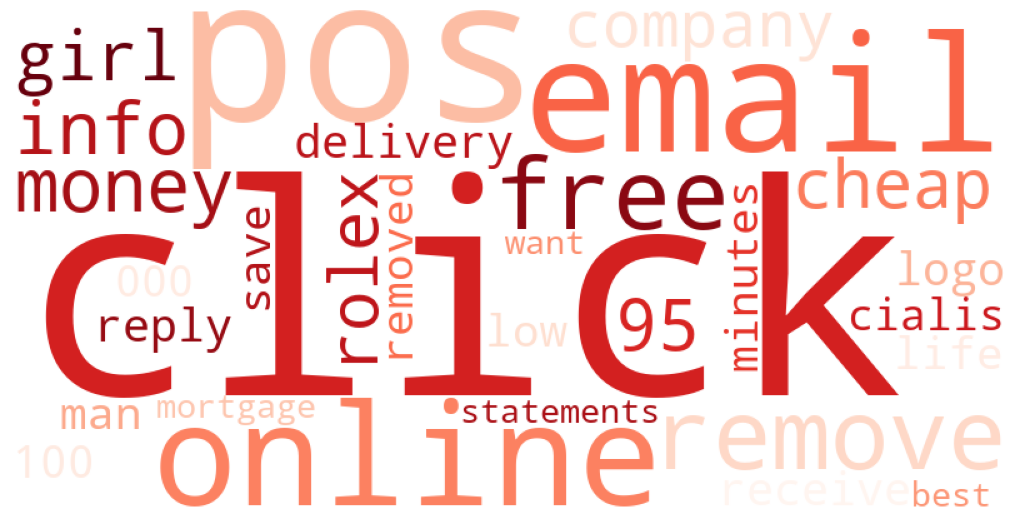

In [33]:
top_30_wordcloud_p = WordCloud(width=800, height=400, background_color="white", colormap='Reds').generate_from_frequencies(top_30_positive)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(top_30_wordcloud_p)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../OUTPUT/reg_phishing_wordcloud.png')
plt.show()

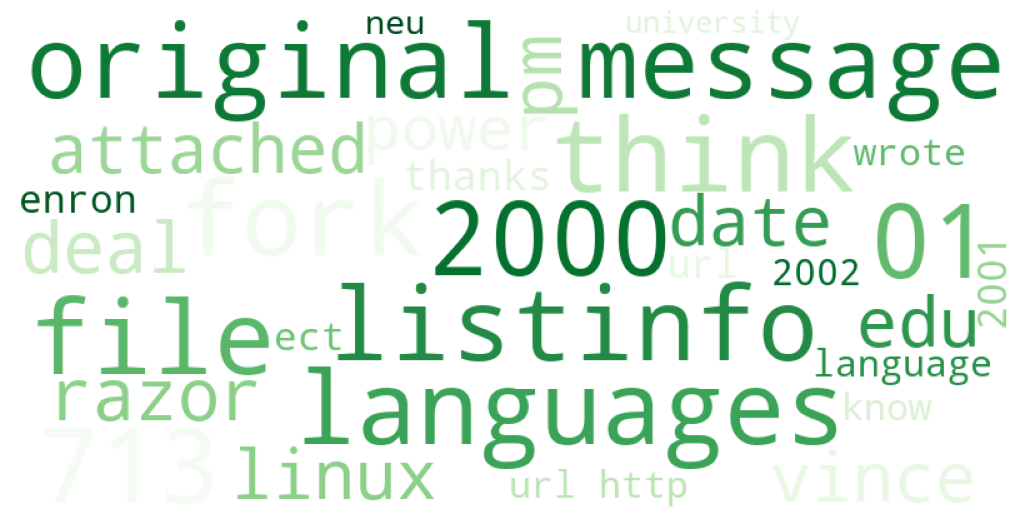

In [34]:
top_30_wordcloud_n = WordCloud(width=800, height=400, background_color="white", colormap='Greens').generate_from_frequencies(top_30_negative)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(top_30_wordcloud_n)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../OUTPUT/reg_safe_wordcloud.png')
plt.show()